# Self-Driving Car Engineer Nanodegree


## Project 5: **Vehicle Detection and Tracking** 
***
### The Goal of this Project
In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the [project repository](https://github.com/udacity/CarND-Vehicle-Detection). There is an [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) in the repository provided as a starting point for your writeup of the project.


### The steps of this project are the following:

#### I - Extract Features
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

#### II - Build and Train a Classifier
* Train a classifier Linear SVM classifier.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

#### III - Conduct a Sliding Window Search
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

#### IV - Video Implementation
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
#### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


### Given Images
```
[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4
```

#![alt text][image2]

### Explore Data

#### 1. Imports

In [1]:
# Imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# else use this:
#from sklearn.cross_validation import train_test_split

import pickle

from scipy.ndimage.measurements import label


#### 2. Read the training images (vehicle and non-vehicle).

In [2]:
# Read in all the vehicles and non-vehicle images
# Randomly display one example for vehicle and non-vehicle images

path_v = 'project_datasets/vehicles/'
path_nv = 'project_datasets/non-vehicles/'

images_cars = os.listdir(path_v)
images_notcars = os.listdir(path_nv)

cars = []
notcars = []

for image_c in images_cars:
        cars.extend(glob.glob(path_v+image_c+'/*'))
        
for image_nc in images_notcars:
        notcars.extend(glob.glob(path_nv+image_nc+'/*'))
        


#### 3. Explore data

Number of vehicle images:  8792
Number of non-vehicle images:  8968


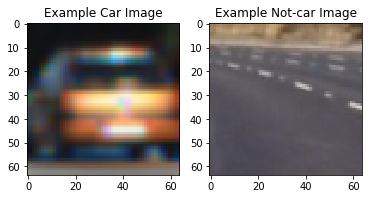

In [3]:
# Explore data

print('Number of vehicle images: ', len(cars)) 
print('Number of non-vehicle images: ', len(notcars)) 

# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
#car_image = mpimg.imread(cars[car_ind])
#notcar_image = mpimg.imread(notcars[notcar_ind])

car_image = cv2.imread(cars[car_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)

notcar_image = cv2.imread(notcars[car_ind])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.title('Example Car Image')
plt.imshow(car_image)
plt.subplot(122)
plt.title('Example Not-car Image')
plt.imshow(notcar_image); #semi-colon to supress unwanted output

### I -  Extract Features

#### 1. Extract binned color feature

In [4]:
# Define a function to compute binned color feature  
# This is scaling down the resolution of an image
def bin_spatial(img, size=(32, 32), vis='False'):
    small_img = cv2.resize(img, size)
    # Use cv2.resize().ravel() to create the feature vector
    feature = small_img.ravel() 
    # Return the feature vector
    if (vis == 'False'):
        return feature
    else:
        return feature,  small_img

image= (64, 64, 3)
small_image= (32, 32, 3)
feature= (3072,)


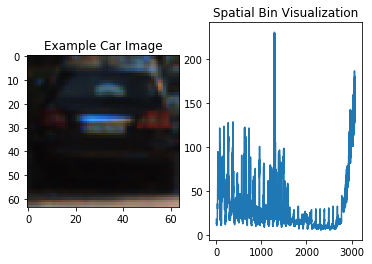

In [5]:
# Test bin_spatial()

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
#image_s = mpimg.imread(cars[ind])

image_s = cv2.imread(cars[ind]) 
image_s = cv2.cvtColor(image_s, cv2.COLOR_BGR2RGB)


print("image=", image_s.shape)
# Define spatial bin parameters
size=(32, 32)
feature_bin, small_image = bin_spatial(image_s, size=size, vis='True')
print("small_image=", small_image.shape)
print("feature=", feature_bin.shape)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image_s)
plt.title('Example Car Image')
plt.subplot(122)
plt.plot(feature_bin)
plt.title('Spatial Bin Visualization');

#### 2. Extract histogram of color

In [6]:
# Define a function to compute color histogram feature 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256),vis='False'):
    # Compute the histogram of the color channels separately
    # Take histograms in R, G, and B
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_feature = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    if (vis == 'False'):
        return hist_feature
    else:
        return hist_feature, rhist, ghist, bhist

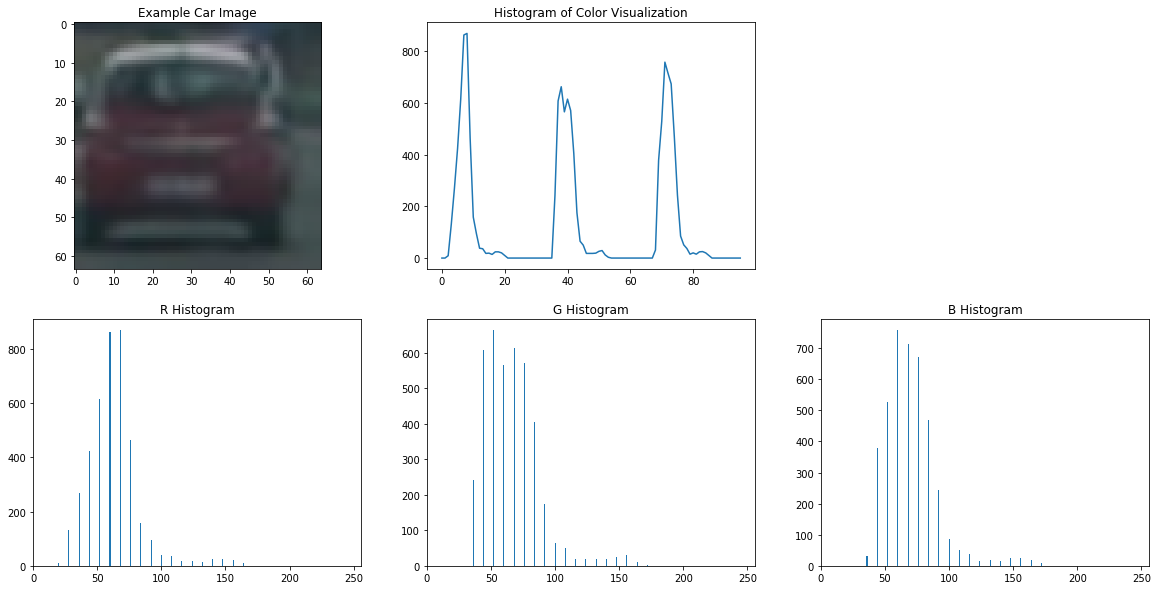

In [7]:
# Test color_hist()

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
#image_h = mpimg.imread(cars[ind]) #histogram scale [0,1]
image = cv2.imread(cars[ind]) #histogram scale [0,255]
image_h = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define histogram of color parameters
nbins = 32
bins_range=(0, 256)

hist_feature, rhist, ghist, bhist  = color_hist(image_h, nbins=nbins, bins_range=bins_range, vis='True')

# Generating bin centers
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot the example image and histogram
fig = plt.figure(figsize=(20,10))

plt.subplot(231)
plt.imshow(image_h)
plt.title('Example Car Image')

plt.subplot(232)
plt.plot(hist_feature)
plt.title('Histogram of Color Visualization')

plt.subplot(234)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')

plt.subplot(235)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')

plt.subplot(236)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram');


#### 3. Extract histogram of gradient (HOG)

In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, 
                                  feature_vector=False)
                                  #block_norm='L2-Hys')
        return features, hog_image
    else:
        # Use skimage.hog() to get features only
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, 
                       feature_vector=feature_vec)
                       #block_norm='L2-Hys')
        return features

/Users/preetichauhan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


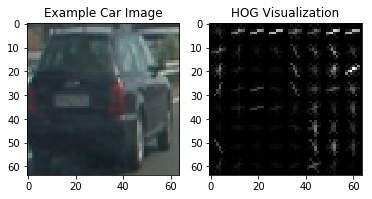

In [9]:
# Test get_hog_features()

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
#image = mpimg.imread(cars[ind])
image = cv2.imread(cars[ind]) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');


#### 4. Combine and extract features

In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.imread(file) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
              

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    



#### 5. Normalize features

In [11]:
# normalize feature
def normalize(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return X, scaled_X

#### 6. Plot an example

In [12]:
# Plot an example of raw and scaled features
def plot_image_info(img1, d1, d2, t1, t2, t3):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(cv2.imread(img1), cv2.COLOR_BGR2RGB))
    plt.title(t1)
    plt.subplot(132)
    plt.plot(d1)
    plt.title(t2)
    plt.subplot(133)
    plt.plot(d2)
    plt.title(t3)
    fig.tight_layout()

/Users/preetichauhan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


32.97 Seconds to extract features...


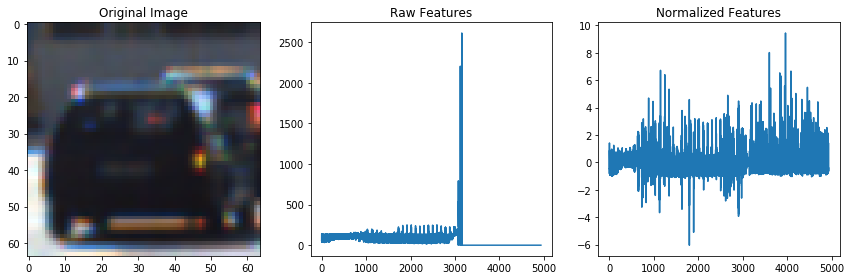

In [13]:
# Test normalize() and plot_image_info()

color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel=0
spatial_feat=True
hist_feat=True
hog_feat=True
    
t=time.time()
car_features = extract_features(cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)
    


notcar_features = extract_features(notcars, 
                                   color_space=color_space, 
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, 
                                   hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

if len(car_features) > 0:
    X, scaled_X = normalize(car_features, notcar_features)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    plot_image_info(cars[car_ind], X[car_ind], scaled_X[car_ind],
                'Original Image', 'Raw Features', 'Normalized Features')  
else: 
    print('Your function only returns empty feature vectors...')

### II - Build and Train a Classifier

#### 1. Linear SVM Classifier

In [14]:
# Train a linear SVM

def classifier(car_features, notcar_features, X, scaled_X):
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

#### 2. Combine Feature Extraction, Normalization and Classifier

In [15]:
# Combining and tuning parameters to get best performance
def feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                       spatial_size = (32, 32), 
                       hist_bins=32,  
                       orient = 9,
                       pix_per_cell = 8,
                       cell_per_block = 2,
                       hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                       spatial_feat=True,
                       hist_feat=True,
                       hog_feat=True): 
 
    t=time.time()
 

    car_features = extract_features(cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)



    notcar_features = extract_features(notcars, 
                                   color_space=color_space, 
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, 
                                   hog_feat=hog_feat)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')

    X, scaled_X = normalize(car_features, notcar_features)

    classifier(car_features, notcar_features, X, scaled_X)


#### 3.  Experiment with parameters

#### (i) Exploring Color Space

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'HLS', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True)

In [ ]:
feature_classifier(color_space = 'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True)

In [ ]:
feature_classifier(color_space = 'HSV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'RGB', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

#### (ii) Exploring spatial_size 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (64, 64), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (16, 16), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (8, 8), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

#### (iii) Exploring orient 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 10,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 8,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

#### (iv) Exploring pix_per_cell

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 9,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 7,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

#### (v) Exploring cell_per_block

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 4,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 8,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

#### (vi) Exploring hog_channel

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 0, # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 1, # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

In [ ]:
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 2, # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 

####  Final Choice

#### Summary:

Based on the above experiments, I decided to choose the following parameters:
```
feature_classifier(color_space = 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
                   spatial_size = (32, 32), 
                   hist_bins=32,  
                   orient = 9,
                   pix_per_cell = 8,
                   cell_per_block = 2,
                   hog_channel = 'ALL', # Can be 0, 1, 2, or "ALL"
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True) 
```


### III -Sliding Window Search

#### 1. Implement a sliding window search.  
- Decide what scales to search?
- How much to overlap windows?

In [16]:
# Sliding Window Search
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# draw_boxes function 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



#### Search and Classify

In [17]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = np.copy(img)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [18]:
# Complete Pipeline with selected parameters
    
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
spatial_size = (32, 32) 
hist_bins=32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_feat=True
hist_feat=True
hog_feat=True
                    
t=time.time()


car_features = extract_features(cars, 
                            color_space=color_space, 
                            spatial_size=spatial_size,
                            hist_bins=hist_bins, 
                            orient=orient, 
                            pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, 
                            hog_feat=hog_feat)



notcar_features = extract_features(notcars, 
                               color_space=color_space, 
                               spatial_size=spatial_size,
                               hist_bins=hist_bins, 
                               orient=orient, 
                               pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel,
                               spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, 
                               hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler 
dist_pickle["orient"] = orient 
dist_pickle["pix_per_cell"] = pix_per_cell 
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size 
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("output_images/svc_pickle.p", "wb" ) )


/Users/preetichauhan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


71.21 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
11.65 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00133 Seconds to predict 10 labels with SVC


#### Hog Sub-sampling Window Search

In [37]:
# Hog Sub-sampling Window Search

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


In [38]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [44]:
# Visualize Results
def visualize_results(img1, img2, img3, str1, str2, str3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    f.tight_layout()
    
    ax1.imshow(img1)
    ax1.set_title(str1, fontsize=30)
    
    ax2.imshow(img2)
    ax2.set_title(str2, fontsize=30)
    
    ax3.imshow(img3, cmap='hot')
    ax3.set_title(str3, fontsize=30)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)

/Users/preetichauhan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


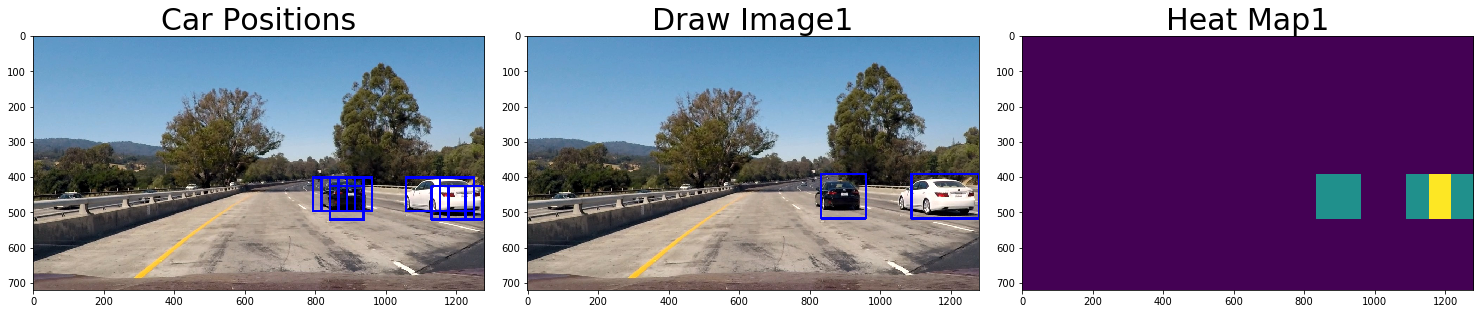

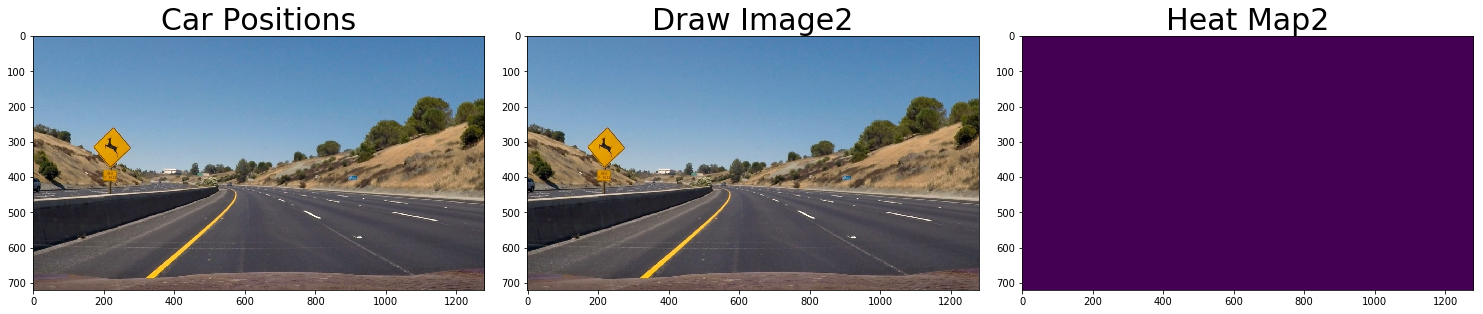

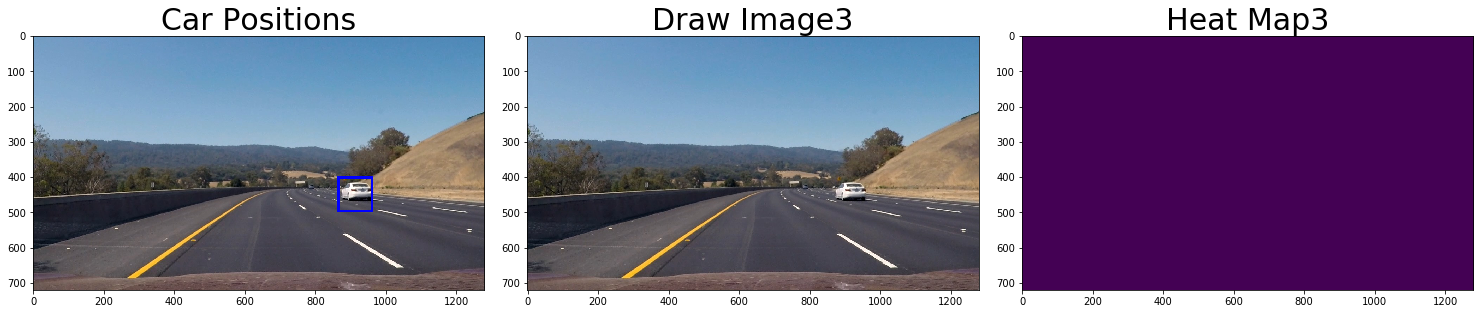

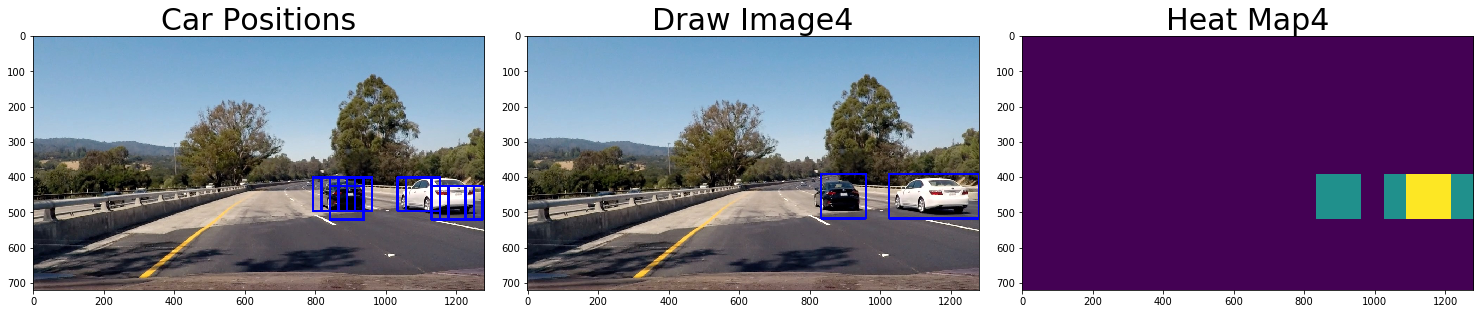

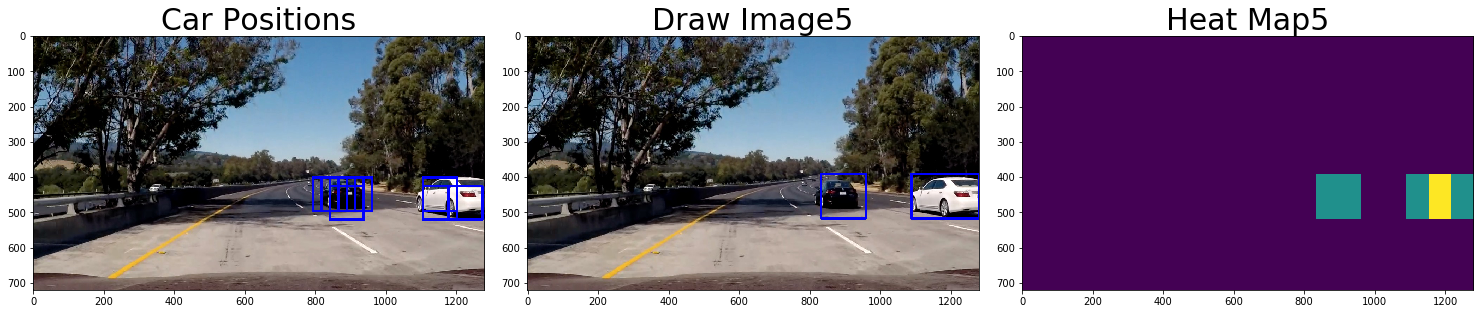

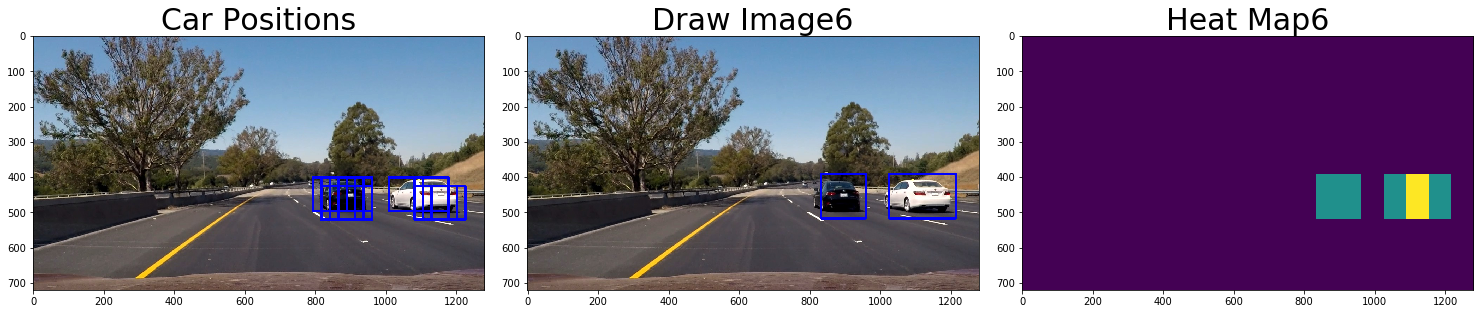

In [45]:
# Test Hog Sub-sampling Window Search

%matplotlib inline

dist_pickle = pickle.load( open("output_images/svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

ystart = 400
ystop = 656

scale = 1.5
test_images = sorted(glob.glob('test_images/test*'))
for idx, pname in enumerate(test_images):
    img = cv2.imread(pname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128,128), xy_overlap=(0.5, 0.5))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)  

    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)    
    

    heatz = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    box_list = hot_windows
    heat1 = add_heat(heatz,box_list)

    # Apply threshold to help remove false positives
    heat2 = apply_threshold(heat1,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat2, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    visualize_results(out_img, draw_img, heatmap, 
                      'Car Positions', 'Draw Image%s'%(idx+1), 'Heat Map%s'%(idx+1))


###  IV - Video Implementation

#### 1. Test pipeline on the entire project video.
(somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

#### 2. Implement some kind of filter for false positives and some method for combining overlapping bounding boxes.

#### Multiple Detections & False Positives
Correctly identifying where vehicles are on road and where they are not by filtering out false positives and duplicates. Rejecting false positves and correctly combining duplicates. 
Build a heat-map from these detections in order to combine overlapping detections and remove false positives.

- Record the positions of positive detections in each frame of the video. 
- From the positive detections create a heatmap.
- Thresholded that map to identify vehicle positions.
- Use `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.
- Assume each blob corresponded to a vehicle, construct bounding boxes to cover the area of each blob detected.
- Display result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video.

#### Here are six frames and their corresponding heatmaps:

#### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:

#### Here the resulting bounding boxes are drawn onto the last frame in the series:

#### 3. Here's a [link to my video result](./project_video_result.mp4).

### Discussion

#### Problems / issues aced in implementation of this project.  
- What approach and techniques were used?
- What worked and why?
- Where will the pipeline likely fail?  
- What could be further done to improve and make it more robust?